In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from stack_segmentation.stack import Stack

In [5]:
from stack_segmentation.io import make_dataloader, collate_fn_basic

from stack_segmentation.training import (
    handle_stacks_data, 
    make_optimization_task, 
    train_loop
)

from stack_segmentation.pipeline_config import (
    dataloaders_conf,
    train_conf,
    model_config, 
    aug_config,
    optimizer_config,
    loss_config,
    scheduler_config,
)

In [6]:
from exp_config import data_conf

## Parameters to tune

In [7]:
train_conf['device'] = 'cuda:1'
# train_conf['device'] = 'cpu'
train_conf['num_epochs'] = 500
train_conf

{'num_epochs': 500, 'device': 'cuda:1'}

In [8]:
data_conf['conf_name'] = 'exp_basic_adamw_lr1e-3_epoch_300_resnet50_encoder_soft_aug_k_1_weight10_patch64_bs_64'
data_conf['patches'] = {
    'train': (64, 64, 1),
    'val': (64, 64, 1),
    'test': (64, 64, 1)
}
data_conf

{'conf_name': 'exp_basic_adamw_lr1e-3_epoch_300_resnet50_encoder_soft_aug_k_1_weight10_patch64_bs_64',
 'stacks': [{'path': '../../data/carb96558',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(250, 470, None))},
  {'path': '../../data/SoilB-2',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(240, 460, None))},
  {'path': '../../data/Urna_22',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 220, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(245, 455, None))},
  {'path': '../../data/carb96558',
   'slice_test': (slice(None, None, None),
    slice(None, None, None),
    slice(490, None, None))},
  {'path': '../../data/carb71',
   'slice_t

In [9]:
model_config

{'source': 'qubvel',
 'model_type': 'Unet',
 'encoder_name': 'resnet50',
 'encoder_weights': 'imagenet'}

In [10]:
optimizer_config['opt_type'] = 'AdamW'
optimizer_config['lr'] = 1e-3
optimizer_config['weight_decay'] = 5e-5
optimizer_config['amsgrad'] = True
# optimizer_config['nesterov'] = True
optimizer_config

{'opt_type': 'AdamW',
 'lr': 0.001,
 'weight_decay': 5e-05,
 'amsgrad': True,
 'nesterov': False,
 'momentum': 0.9,
 'centered': False}

In [11]:
aug_config['aug_type'] = 'soft'
aug_config['k'] = 1
aug_config['original_height'] = 64
aug_config['original_width'] = 64
aug_config

{'aug_type': 'soft', 'original_height': 64, 'original_width': 64, 'k': 1}

In [12]:
loss_config =[
    {
        'loss': 'BCE', 
        'weight': 1, 
        'params': {'weight': [1, 10]}},
    {
        'loss': 'Dice',
        'weight': 2, 
        'params': {
            'mode': 'multiclass',
            'classes': [1], # может быть, этот параметр не нужен
            'log_loss': True,
            'from_logits': True,
            'smooth': 1,
            'eps': 1e-7
        }
    }
]
loss_config

[{'loss': 'BCE', 'weight': 1, 'params': {'weight': [1, 10]}},
 {'loss': 'Dice',
  'weight': 2,
  'params': {'mode': 'multiclass',
   'classes': [1],
   'log_loss': True,
   'from_logits': True,
   'smooth': 1,
   'eps': 1e-07}}]

In [13]:
dataloaders_conf['train']['batch_size'] = 32
dataloaders_conf['val']['batch_size'] = 32
dataloaders_conf['test']['batch_size'] = 32
dataloaders_conf

{'train': {'batch_size': 32, 'num_workers': 16, 'shuffle': True},
 'val': {'batch_size': 32, 'num_workers': 16, 'shuffle': False},
 'test': {'batch_size': 32, 'num_workers': 16, 'shuffle': True}}

## Prepare train, validation and test data

In [14]:
data_train, data_val, data_test = handle_stacks_data(**data_conf)

720it [00:01, 687.00it/s]
100%|██████████| 720/720 [00:07<00:00, 96.01it/s] 
33120it [00:00, 256152.04it/s]
31680it [00:00, 165998.37it/s]
700it [00:00, 780.19it/s]
100%|██████████| 700/700 [00:06<00:00, 108.98it/s]
27830it [00:00, 148306.16it/s]
26620it [00:00, 253013.60it/s]
710it [00:00, 817.39it/s]
100%|██████████| 710/710 [00:07<00:00, 99.51it/s] 
31680it [00:00, 144956.36it/s]
30240it [00:00, 131674.26it/s]
720it [00:00, 852.05it/s]
100%|██████████| 720/720 [00:07<00:00, 97.82it/s] 
33120it [00:00, 256796.50it/s]
720it [00:00, 843.29it/s]
100%|██████████| 720/720 [00:07<00:00, 96.45it/s] 
103680it [00:00, 181556.14it/s]
700it [00:00, 710.50it/s]
100%|██████████| 700/700 [00:06<00:00, 101.12it/s]
84700it [00:00, 233250.35it/s]
509it [00:00, 1219.12it/s]
100%|██████████| 509/509 [00:02<00:00, 197.45it/s]
32576it [00:00, 95419.16it/s]
700it [00:00, 862.96it/s]
100%|██████████| 700/700 [00:06<00:00, 103.43it/s]
84700it [00:00, 241165.19it/s]
700it [00:00, 836.86it/s]
100%|██████████|

In [15]:
len(data_train), len(data_val), len(data_test)

(92630, 88540, 11)

In [16]:
dataloader_train = make_dataloader(
    samples=data_train, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    aug_config=aug_config,
    **dataloaders_conf['train']
)

dataloader_val = make_dataloader(
    samples=data_val, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    **dataloaders_conf['val']
)

dataloaders_test = {
    name: make_dataloader(
        samples=data, 
        collate_fn=collate_fn_basic,
        model_config=model_config,
        **dataloaders_conf['test']
    ) for name, data in data_test.items()}

## Create model and metrics

In [17]:
device = 'cuda:1'
# device = 'cpu'

In [18]:
model, criterion, optimizer, scheduler = make_optimization_task(
    device,
    model_config=model_config,
    loss_config=loss_config, 
    optimizer_config=optimizer_config,
    scheduler_config=scheduler_config)

## Run experiment

In [19]:
from stack_segmentation.metrics import accuracy, precision, recall, f1, pr_auc, iou

In [20]:
metrics = {
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'pr_auc': pr_auc, 
    'iou': iou,
}

In [21]:
results = train_loop(
    model=model,
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    dataloaders_test=dataloaders_test,
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    metrics=metrics,
    exp_name=data_conf['conf_name'],
    **train_conf)

  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 0...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.055282


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.03059
Epoch 1...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.029457


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.032009
EarlyStopping counter: 1 out of 15
Epoch 2...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.027215


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.040977
EarlyStopping counter: 2 out of 15
Epoch 3...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.026153


100%|██████████| 2767/2767 [00:53<00:00, 51.85it/s]


Mean val loss: 0.025263


  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 4...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.025439


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.027241
EarlyStopping counter: 1 out of 15
Epoch 5...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.024813


100%|██████████| 2767/2767 [00:53<00:00, 51.82it/s]


Mean val loss: 0.024429


  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 6...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.024424


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.026095
EarlyStopping counter: 1 out of 15
Epoch 7...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.024097


100%|██████████| 2767/2767 [00:53<00:00, 51.87it/s]


Mean val loss: 0.023715


  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 8...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.023799


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.023857
EarlyStopping counter: 1 out of 15
Epoch 9...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.023565


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.024808
EarlyStopping counter: 2 out of 15
Epoch 10...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.023404


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.024755
EarlyStopping counter: 3 out of 15
Epoch 11...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.023151


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.024286
EarlyStopping counter: 4 out of 15
Epoch 12...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.022944


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.025608
EarlyStopping counter: 5 out of 15
Epoch 13...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.022896


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.023949
EarlyStopping counter: 6 out of 15
Epoch 14...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.022724


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.02558
EarlyStopping counter: 7 out of 15
Epoch 15...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.022583


100%|██████████| 2767/2767 [00:53<00:00, 51.77it/s]


Mean val loss: 0.022926


  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 16...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.022505


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.026971
EarlyStopping counter: 1 out of 15
Epoch 17...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.022346


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.026413
EarlyStopping counter: 2 out of 15
Epoch 18...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.022251


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.024942
EarlyStopping counter: 3 out of 15
Epoch 19...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.022196


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.024079
EarlyStopping counter: 4 out of 15
Epoch 20...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.022132


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.024612
EarlyStopping counter: 5 out of 15
Epoch 21...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021974


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.024634
EarlyStopping counter: 6 out of 15
Epoch 22...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.022002


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.023911
EarlyStopping counter: 7 out of 15
Epoch 23...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021842


100%|██████████| 2767/2767 [00:53<00:00, 51.82it/s]


Mean val loss: 0.022237


  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 24...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021757


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.022417
EarlyStopping counter: 1 out of 15
Epoch 25...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021714


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.022536
EarlyStopping counter: 2 out of 15
Epoch 26...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.02166


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.02319
EarlyStopping counter: 3 out of 15
Epoch 27...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021564


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.022398
EarlyStopping counter: 4 out of 15
Epoch 28...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021567


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.022553
EarlyStopping counter: 5 out of 15
Epoch 29...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021483


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.022286
EarlyStopping counter: 6 out of 15
Epoch 30...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021451


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.022271
EarlyStopping counter: 7 out of 15
Epoch 31...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021387


100%|██████████| 2767/2767 [00:53<00:00, 51.52it/s]


Mean val loss: 0.021905


  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 32...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021436


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.02575
EarlyStopping counter: 1 out of 15
Epoch 33...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021313


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.022157
EarlyStopping counter: 2 out of 15
Epoch 34...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021271


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.024722
EarlyStopping counter: 3 out of 15
Epoch 35...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021223


100%|██████████| 2767/2767 [00:53<00:00, 51.70it/s]


Mean val loss: 0.021691


  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 36...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021192


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021825
EarlyStopping counter: 1 out of 15
Epoch 37...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021196


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021892
EarlyStopping counter: 2 out of 15
Epoch 38...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021156


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021829
EarlyStopping counter: 3 out of 15
Epoch 39...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021134


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.022753
EarlyStopping counter: 4 out of 15
Epoch 40...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021051


100%|██████████| 2767/2767 [00:53<00:00, 51.78it/s]


Mean val loss: 0.021639


  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 41...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021071


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021845
EarlyStopping counter: 1 out of 15
Epoch 42...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.02102


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.025327
EarlyStopping counter: 2 out of 15
Epoch 43...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.021005


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021679
EarlyStopping counter: 3 out of 15
Epoch 44...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020955


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021685
EarlyStopping counter: 4 out of 15
Epoch 45...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020936


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.02197
EarlyStopping counter: 5 out of 15
Epoch 46...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020895


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.024016
EarlyStopping counter: 6 out of 15
Epoch 47...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020882


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.023485
EarlyStopping counter: 7 out of 15
Epoch 48...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020842


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.023477
EarlyStopping counter: 8 out of 15
Epoch 49...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020846


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.022659
EarlyStopping counter: 9 out of 15
Epoch 50...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020872


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021692
EarlyStopping counter: 10 out of 15
Epoch 51...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020806


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021771
EarlyStopping counter: 11 out of 15
Epoch 52...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020779


100%|██████████| 2767/2767 [00:53<00:00, 51.87it/s]


Mean val loss: 0.021482


  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 53...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020752


100%|██████████| 2767/2767 [00:53<00:00, 51.78it/s]


Mean val loss: 0.02145


  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 54...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020723


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.025713
EarlyStopping counter: 1 out of 15
Epoch 55...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020743


100%|██████████| 2767/2767 [00:53<00:00, 51.70it/s]


Mean val loss: 0.021451


  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 56...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020678


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021553
EarlyStopping counter: 1 out of 15
Epoch 57...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020655


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.0216
EarlyStopping counter: 2 out of 15
Epoch 58...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020683


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021822
EarlyStopping counter: 3 out of 15
Epoch 59...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020636


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.022373
EarlyStopping counter: 4 out of 15
Epoch 60...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020626


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.022212
EarlyStopping counter: 5 out of 15
Epoch 61...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020593


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021955
EarlyStopping counter: 6 out of 15
Epoch 62...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.02056


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.023123
EarlyStopping counter: 7 out of 15
Epoch 63...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020561


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021707
EarlyStopping counter: 8 out of 15
Epoch 64...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020539


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021852
EarlyStopping counter: 9 out of 15
Epoch 65...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020516


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.023513
EarlyStopping counter: 10 out of 15
Epoch 66...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020514


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021876
EarlyStopping counter: 11 out of 15
Epoch 67...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020446


100%|██████████| 2767/2767 [00:53<00:00, 51.85it/s]


Mean val loss: 0.021437


  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 68...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020451


100%|██████████| 2767/2767 [00:53<00:00, 51.47it/s]


Mean val loss: 0.021108


  0%|          | 0/2895 [00:00<?, ?it/s]

Epoch 69...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020448


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.02435
EarlyStopping counter: 1 out of 15
Epoch 70...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020419


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.025687
EarlyStopping counter: 2 out of 15
Epoch 71...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020391


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021288
EarlyStopping counter: 3 out of 15
Epoch 72...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020393


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.024608
EarlyStopping counter: 4 out of 15
Epoch 73...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020362


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.02123
EarlyStopping counter: 5 out of 15
Epoch 74...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020332


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.026483
EarlyStopping counter: 6 out of 15
Epoch 75...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020374


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.0212
EarlyStopping counter: 7 out of 15
Epoch 76...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.02032


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021199
EarlyStopping counter: 8 out of 15
Epoch 77...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020299


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.035554
EarlyStopping counter: 9 out of 15
Epoch 78...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020298


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.02133
EarlyStopping counter: 10 out of 15
Epoch 79...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020248


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.022665
EarlyStopping counter: 11 out of 15
Epoch 80...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020251


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.022251
EarlyStopping counter: 12 out of 15
Epoch 81...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020239


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021726
EarlyStopping counter: 13 out of 15
Epoch 82...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020184


  0%|          | 0/2895 [00:00<?, ?it/s]

Mean val loss: 0.021512
EarlyStopping counter: 14 out of 15
Epoch 83...


  0%|          | 0/2767 [00:00<?, ?it/s]

Mean train loss: 0.020174


  0%|          | 0/1035 [00:00<?, ?it/s]

Mean val loss: 0.021647
EarlyStopping counter: 15 out of 15


100%|██████████| 2647/2647 [07:14<00:00,  6.09it/s]


## Dump experiment results

In [22]:
import pickle
import json

In [23]:
p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
with open(p, 'wb') as f:
    pickle.dump(results, f)

In [28]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'rb') as f:
#     results = pickle.load(f)

In [11]:
import torch
model.load_state_dict(torch.load('./{}.pt'.format(data_conf['conf_name'])))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Train and validation losses

In [24]:
from itertools import chain

In [25]:
train_losses = list(chain(*[item for item in results['train_losses']]))
val_losses = list(chain(*[item for item in results['val_losses']]))

In [26]:
def moving_average(a, n=5) :
    ret = np.cumsum([a[0]] * (n - 1) + a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

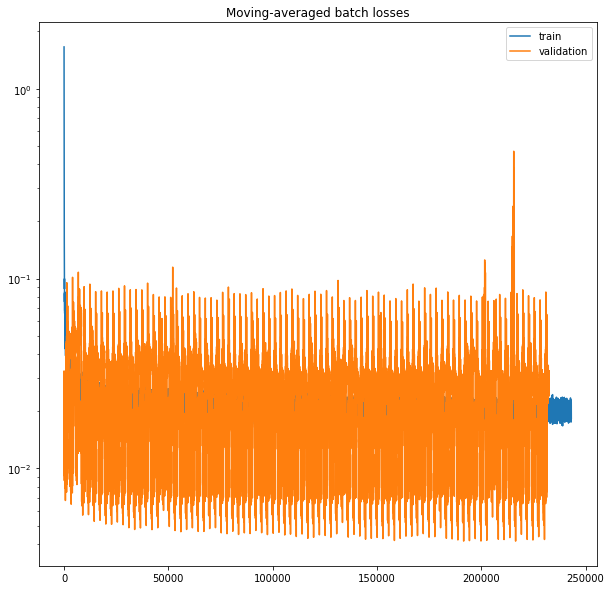

In [27]:
plt.figure(figsize=(10, 10))
plt.title('Moving-averaged batch losses')
plt.plot(np.arange(len(train_losses)), moving_average(train_losses), label='train')
plt.plot(np.arange(len(val_losses)), moving_average(val_losses), label='validation')

plt.legend(loc='best')
plt.yscale('log')

# plt.ylim([1e-2, 1])
plt.show()

In [28]:
mean_train_loss = [np.mean(item) for item in results['train_losses']]
mean_val_loss = [np.mean(item) for item in results['val_losses']]

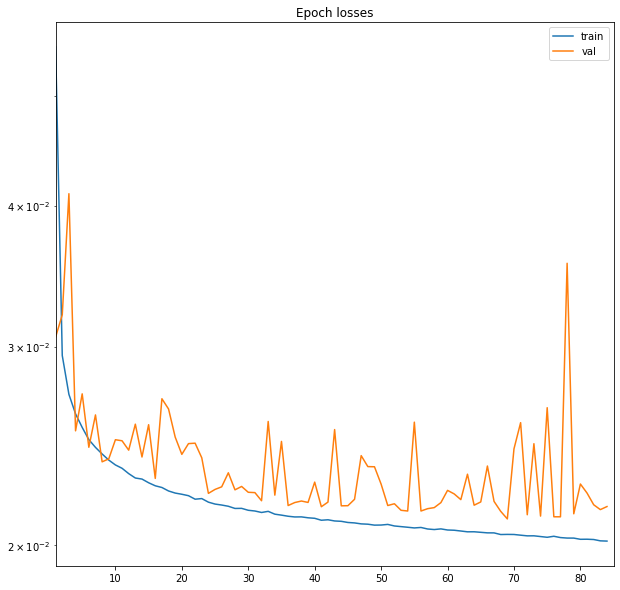

In [29]:
plt.figure(figsize=(10, 10))
plt.title('Epoch losses')
plt.plot(np.arange(len(mean_train_loss)) + 1, mean_train_loss, label='train')
plt.plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, label='val')

plt.yscale('log')
plt.legend(loc='best')

plt.xlim([1, len(mean_train_loss) + 1])
plt.show()

## Results

In [30]:
import pandas as pd

In [31]:
from visualization_utils import make_df

In [32]:
df = make_df(results, model_name='basic')
df

,accuracy,precision,recall,f1,pr_auc,iou,stack,model
0,0.996811,0.954205,0.997468,0.975357,0.998739,0.951899,carb96558,basic
1,0.985481,0.884455,0.997132,0.937420,0.981298,0.882211,carb71,basic
2,0.983677,0.921264,0.931881,0.926542,0.975031,0.863138,carbRNF,basic
3,0.995384,0.989903,0.958351,0.973872,0.998054,0.949074,SPE_carb10_58_box3,basic
4,0.991813,0.957466,0.925844,0.941389,0.990293,0.889269,SoilAh-1,basic
5,0.995980,0.918919,0.992803,0.954433,0.997300,0.912838,SoilB-2,basic
6,0.991714,0.994229,0.938943,0.965795,0.983963,0.933853,TeTree_subset1,basic
7,0.995110,0.992405,0.948365,0.969885,0.987089,0.941531,TiTree_subset2,basic
8,0.991570,0.946282,0.995589,0.970309,0.998272,0.942331,Urna_22,basic
9,0.990562,0.960468,0.986133,0.973131,0.998036,0.947669,Urna_30,basic


In [33]:
print('Mean   IOU: {:.5}'.format(df['iou'].mean()))
print('Std    IOU: {:.5}'.format(df['iou'].std()))
print('Min    IOU: {:.5}'.format(df['iou'].min()))
print('Median IOU: {:.5}'.format(df['iou'].median()))

Mean   IOU: 0.92023
Std    IOU: 0.030928
Min    IOU: 0.86314
Median IOU: 0.93385


## Check loss to loss ratio

In [34]:
criterion.losses

(WeightedLoss(
   (loss): CrossEntropyLoss()
 ), WeightedLoss(
   (loss): DiceLoss()
 ))

In [35]:
from stack_segmentation.training import make_joint_loss

In [36]:
import torch

In [37]:
# loss_config[0] = {'loss': 'BCE',
#   'weight': 0.5,
#   'params': {}}
# loss_config
# crit = make_joint_loss(device=device, loss_config=loss_config)

In [38]:
crit = criterion
a = []
b = []
for i, (x, y) in enumerate(dataloader_val):
    if i > 100:
        break
    pred = model(torch.from_numpy(x).to(device))
    y = torch.from_numpy(y).to(device)
    a.append(crit.losses[0](pred, y).cpu().data.numpy())
    b.append(crit.losses[1](pred, y).cpu().data.numpy())

In [39]:
print('Mean 0 loss: {:.4f}\nMean 1 loss: {:.4f}\nMean of ratios: {:.4f}\nRatio of means: {:.4f}'
      .format(np.mean(a), np.mean(b), np.mean(np.array(a) / np.array(b)), np.mean(a) / np.mean(b)))

Mean 0 loss: 0.0089
Mean 1 loss: 0.0044
Mean of ratios: 2.3496
Ratio of means: 2.0086
